In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from shapely import wkt


from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes

In [2]:
import seaborn as jks
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

In [3]:
demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
d23 = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_23.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)

full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
jk = full_results[full_results['candidate'] == 'Jaslin Kaur']


full_results_twenty_three = full_results[full_results['district'] == 23]
winner_twenty_three = full_results_twenty_three[full_results_twenty_three['winner'] == True]
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')
eds_23 = full_results_twenty_three['ed_name'].unique().tolist()
ae = pd.read_csv('../../cc_election_cleaning/ae_precincts.csv')

In [4]:
av = pd.read_csv('../../cc_election_cleaning/additional_variables.csv')
fwe = pd.read_csv('../data/finance_with_ethnicity.csv')
f_plus = pd.read_csv('../../council_campaign_finance/data/iwrl_plus.csv')
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')

In [5]:
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']
wp_cols = [col for col in wp_cols if col not in to_remove]
demo_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21']

jk = gpd.GeoDataFrame(jk,geometry=jk['geometry'].apply(wkt.loads))
jk = jk.set_crs(epsg=2263, allow_override=True)
co_3857 = jk.to_crs(epsg=3857)

In [ ]:
full_results_twenty_three.groupby('candidate')['vote'].sum().sort_values(ascending=False)

In [8]:
top_three = full_results_twenty_three[full_results_twenty_three['candidate'].isin(['Linda Lee','Jaslin Kaur','Steve Behar'])]
winners = top_three.loc[top_three.groupby('ed_name')['vote_share'].idxmax()].copy()
winners['norm'] = winners.groupby('candidate')['vote_share'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)


In [9]:
winners['candidate'].value_counts()

candidate
Jaslin Kaur    52
Linda Lee      51
Steve Behar     6
Name: count, dtype: int64

In [10]:
def assign_color(row):
    if row['candidate'] == 'Linda Lee':
        return mpl.cm.Blues(row['norm'])
    elif row['candidate'] =='Jaslin Kaur':
        return mpl.cm.Reds(row['norm'])
    else:
        return mpl.cm.Greens(row['norm'])
    
winners['color'] = winners.apply(assign_color, axis=1)

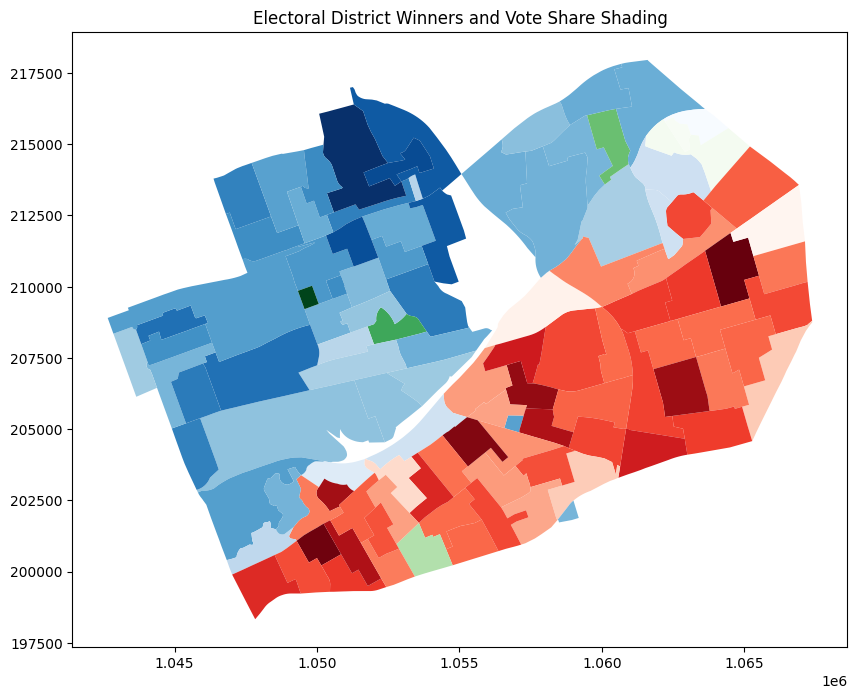

In [11]:
winners = gpd.GeoDataFrame(winners,geometry=winners['geometry'].apply(wkt.loads))

fig, ax = plt.subplots(1, figsize=(10, 10))
winners.plot(color=winners['color'], ax=ax)
ax.set_title("Electoral District Winners and Vote Share Shading")
plt.show()

In [12]:
import contextily as ctx
import seaborn as sns
import matplotlib.patches as mpatches

In [14]:
winners['candidate'].value_counts()

candidate
Jaslin Kaur    52
Linda Lee      51
Steve Behar     6
Name: count, dtype: int64

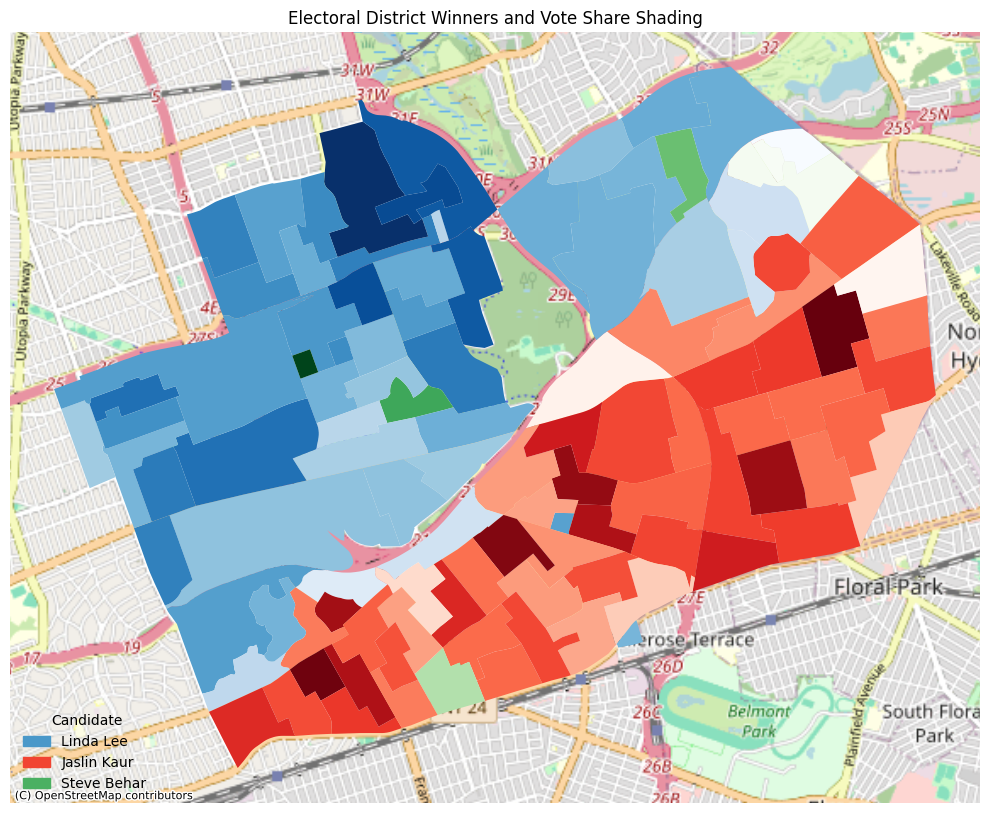

In [15]:
winners  = winners .set_crs(epsg=2263, allow_override=True)
winners_3857 = winners .to_crs(epsg=3857)

fig, ax = plt.subplots(1, figsize=(10, 10))
winners_3857.plot(color=winners['color'], ax=ax)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

handles = [
    mpatches.Patch(color=mpl.cm.Blues(0.6),  label="Linda Lee"),
    mpatches.Patch(color=mpl.cm.Reds(0.6),   label="Jaslin Kaur"),
    mpatches.Patch(color=mpl.cm.Greens(0.6), label="Steve Behar ")
]

ax.legend(
    handles=handles,
    title="Candidate",
    loc="lower left",
    frameon=False
)
ax.set_axis_off()
plt.tight_layout()
ax.set_title("Electoral District Winners and Vote Share Shading")
plt.show()

In [8]:
winner_twenty_three_map = gpd.GeoDataFrame(winner_twenty_three,geometry=winner_twenty_three['geometry'].apply(wkt.loads))

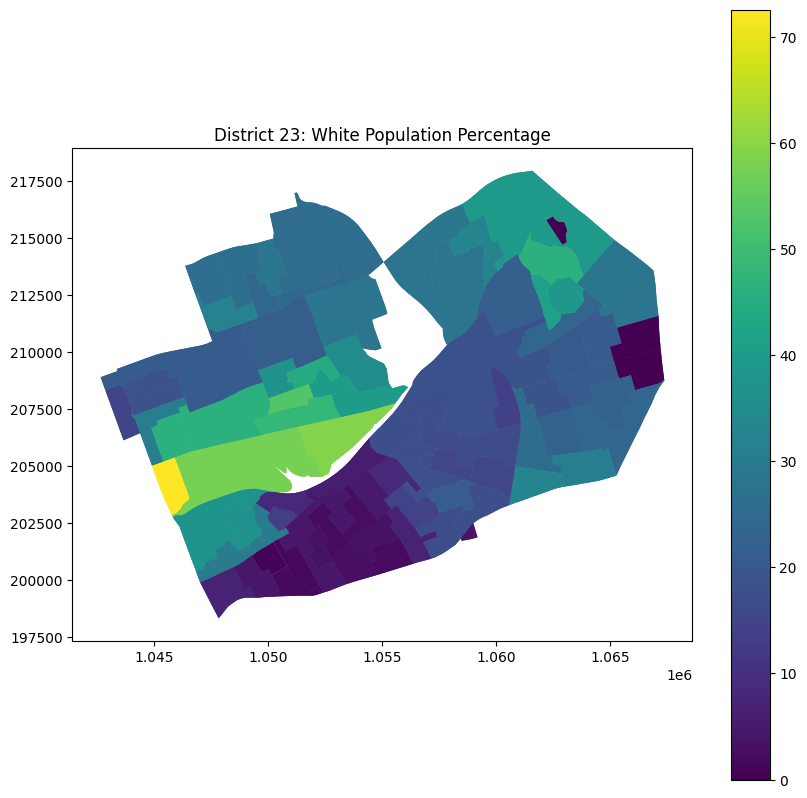

In [23]:
winner_twenty_three_map.plot(column='nhw21p',legend=True,figsize=(10,10),cmap='viridis')
plt.title('District 23: White Population Percentage')
plt.show()

In [14]:
eth_cols = ['ind21p','bang21p','chin21p','filip21p','kor21p','nep21p','pak21p','sril21p','taiw21p','thai21p','viet21p']

In [15]:
winners[['candidate','ed_name']].merge(ae,left_on='ed_name',right_on='ElectDist').groupby('candidate')[eth_cols].mean()    

,ind21p,bang21p,chin21p,filip21p,kor21p,nep21p,pak21p,sril21p,taiw21p,thai21p,viet21p
candidate,,,,,,,,,,,
Jaslin Kaur,23.593822,3.605697,4.403801,4.713797,1.078447,0.055856,1.774505,0.214822,0.063402,0.112231,0.060349
Linda Lee,4.681178,0.516295,21.171735,1.876085,8.360457,0.100585,0.784719,0.107429,0.618660,0.070125,0.232904
Steve Behar,4.163214,0.244519,17.025207,0.977580,4.119338,0.031697,0.238244,0.000000,0.288929,0.339253,0.129144


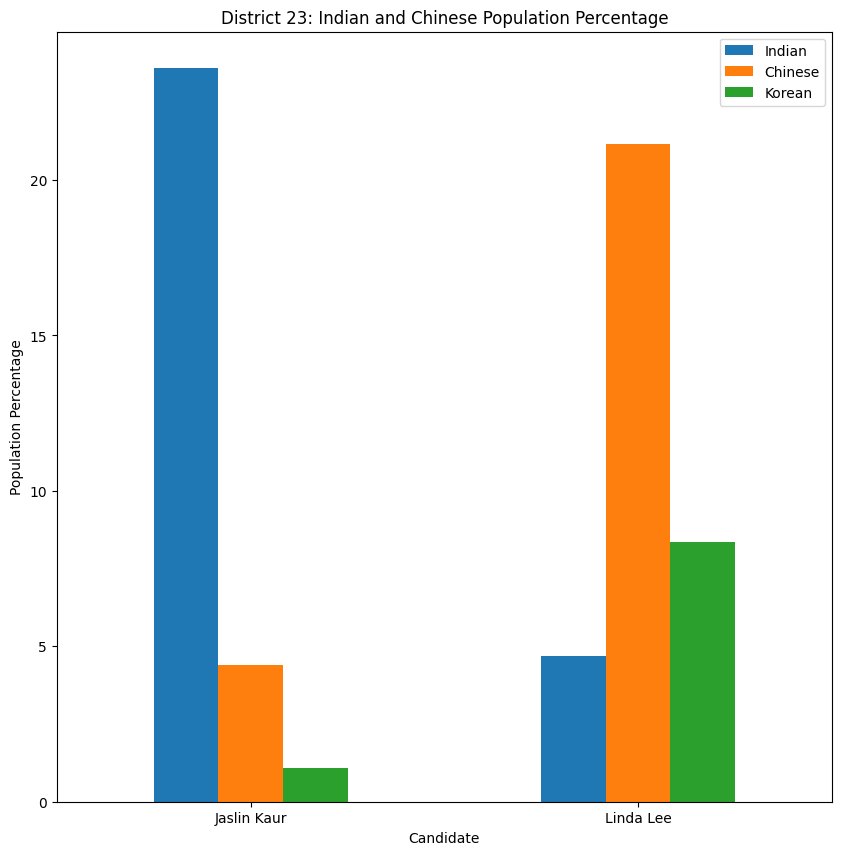

In [ ]:
eth_group = winners[['candidate','ed_name']].merge(ae,left_on='ed_name',right_on='ElectDist')\
    .groupby('candidate')[['ind21p','chin21p','kor21p']].mean().reset_index()

filtered_data = eth_group[eth_group['candidate'].isin(['Linda Lee','Jaslin Kaur'])]

filtered_data.plot(x='candidate', kind='bar', figsize=(10,10))
plt.title('District 23: Share Ethnicity by ED Won')
plt.xlabel('Candidate') 
plt.ylabel('Population Percentage')  
plt.legend(['Indian','Chinese','Korean'])
plt.xticks(rotation=0) 
plt.show()

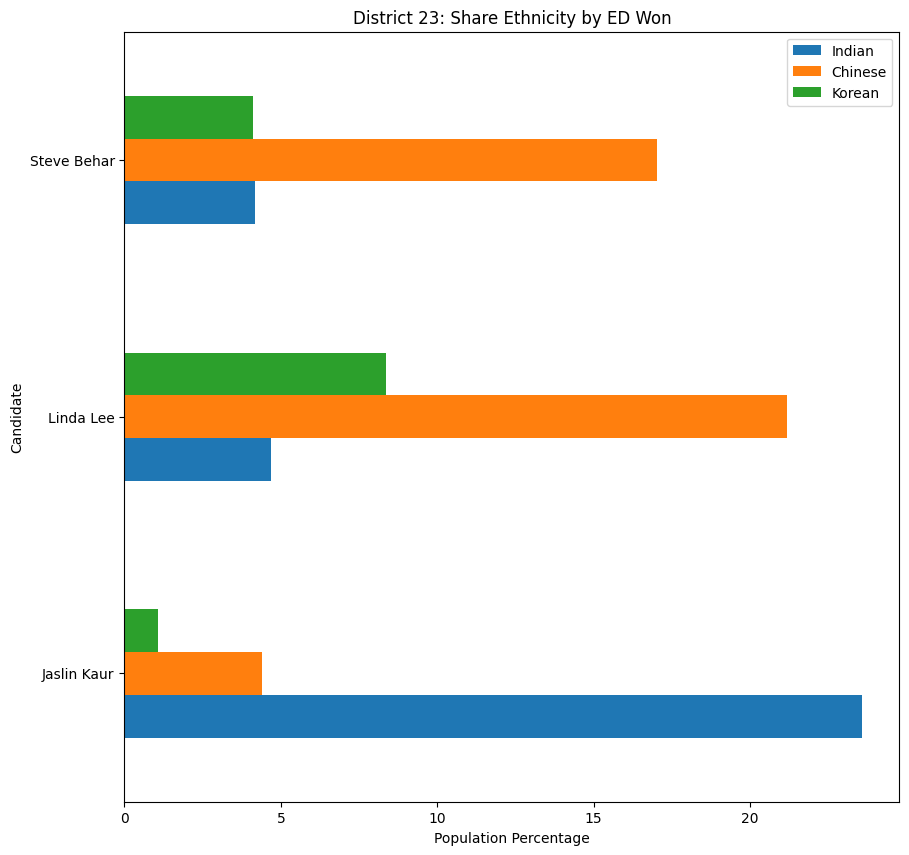

In [17]:
eth_group = winners[['candidate','ed_name']].merge(ae, left_on='ed_name', right_on='ElectDist')\
    .groupby('candidate')[['ind21p','chin21p','kor21p']].mean().reset_index()

filtered_data = eth_group[eth_group['candidate'].isin(['Linda Lee','Jaslin Kaur','Steve Behar'])]

filtered_data.plot(x='candidate', kind='barh', figsize=(10, 10))
plt.title('District 23: Share Ethnicity by ED Won')
plt.ylabel('Candidate')
plt.xlabel('Population Percentage')
plt.legend(['Indian','Chinese','Korean'])
plt.show()

Correlations and EFA

In [ ]:
jk['hh21op']

In [20]:
demo_occ = jk[['vote_share','ed_name','nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21','venez21p','chin21p',
                 'kor21p','colomb21p','domin21p','prican21p','mex21p','white_transplant_ratio','adams213p','winda21p','hh21op']].merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
demo_occ = demo_occ.merge(ae[['ElectDist','ind21p','bang21p','pak21p','filip21p']],on = 'ElectDist',how='left')
demo_occ = demo_occ.merge(av,on='ElectDist',how='left')

In [36]:
demo_occ['log_mhhi21'] = np.log(demo_occ['mhhi21'])

c:\Users\samtg\github\member_chapters\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [39]:
test_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','chin21p','kor21p','white_transplant_ratio',
             'ind21p','bang21p','pak21p','hh21op','adams213p','venez21p','colomb21p','domin21p','prican21p','mex21p'] + wp_cols

In [23]:
cor_matrix = demo_occ[test_cols].corr()
cor_matrix.dropna(subset=('vote_share'),inplace=True)
cor_matrix.sort_values(by='vote_share', ascending=False)

,vote_share,nhw21p,nhb21p,h21p,nha21p,cvap21bapp,chin21p,kor21p,white_transplant_ratio,ind21p,...,w2bgp,w2pservep,w2salep,w2oadp,w2farmp,w2conp,w2emrp,w2prodp,w2tranp,w2matp
vote_share,1.000000,-0.453296,0.351847,0.382101,-0.166459,-0.323137,-0.654928,-0.504249,-0.196190,0.588196,...,0.455015,-0.027130,-0.135052,0.126195,0.137855,0.059350,-0.066749,0.182676,0.317296,0.288762
ind21p,0.588196,-0.292222,-0.099918,0.026329,0.085793,-0.194246,-0.527621,-0.501242,-0.123902,1.000000,...,0.423092,-0.293580,-0.172419,0.191042,0.304546,0.129037,-0.176763,0.069453,0.201504,0.146548
w2bgp,0.455015,-0.390036,0.130698,0.354154,-0.190239,-0.217416,-0.417705,-0.341203,-0.046085,0.423092,...,1.000000,-0.098729,0.040856,0.114820,-0.071218,-0.063726,-0.006471,0.073862,0.141636,0.295586
bang21p,0.433462,-0.529230,0.431948,0.444905,-0.209881,-0.391564,-0.474660,-0.415651,-0.268213,0.089410,...,0.250317,0.116965,-0.109271,0.220887,-0.007745,0.006023,0.080945,0.306625,0.452304,0.319168
h21p,0.382101,-0.419422,0.440071,1.000000,-0.257994,-0.209198,-0.428719,-0.424456,-0.072358,0.026329,...,0.354154,0.129818,-0.245640,-0.015370,0.071697,0.194810,0.052727,0.457774,0.374848,0.300777
adams213p,0.356057,-0.390324,0.797385,0.585288,-0.288605,-0.132183,-0.536766,-0.356332,-0.261603,-0.022364,...,0.157731,0.068194,-0.193111,0.210426,-0.005996,0.113206,0.137843,0.385741,0.303873,0.239096
nhb21p,0.351847,-0.499541,1.000000,0.440071,-0.564876,-0.433093,-0.538635,-0.350470,-0.234132,-0.099918,...,0.130698,0.097076,-0.163259,0.207128,-0.058271,0.010535,0.038894,0.240827,0.346330,0.205371
w2htp,0.326613,-0.431832,0.131330,0.242237,0.114194,-0.286544,-0.195835,-0.225694,-0.283969,0.378333,...,0.124265,-0.089643,-0.015242,0.070956,0.373370,-0.024684,0.100563,0.213484,0.170319,0.245589
w2tranp,0.317296,-0.414462,0.346330,0.374848,-0.069294,-0.459066,-0.286452,-0.319572,-0.230657,0.201504,...,0.141636,0.046053,-0.165959,-0.099540,0.069366,0.183609,0.077772,0.285227,1.000000,0.259985
w2hsp,0.313227,-0.483461,0.312862,0.536155,-0.182066,-0.376441,-0.339663,-0.457999,-0.349753,0.159824,...,0.241574,0.134332,-0.277458,-0.051667,0.200815,0.189373,0.295954,0.501439,0.441569,0.326076


In [53]:
demo_occ[['ind21p','chin21p','kor21p']].corr()

,ind21p,chin21p,kor21p
ind21p,1.000000,-0.527621,-0.501242
chin21p,-0.527621,1.000000,0.713702
kor21p,-0.501242,0.713702,1.000000


In [ ]:
target = demo_occ['vote_share']
mod1 = sm.OLS(target, sm.add_constant(demo_occ[['nhw21p','h21p','cvap21bapp','nha21p']])).fit()
mod2 = sm.OLS(target, sm.add_constant(demo_occ[['nhw21p','h21p','cvap21bapp','nha21p','ind21p']])).fit()
mod3 = sm.OLS(target, sm.add_constant(demo_occ[['nhw21p','h21p','cvap21bapp','nha21p','chin21p']])).fit()
mod4 = sm.OLS(target, sm.add_constant(demo_occ[['nhw21p','h21p','cvap21bapp','nha21p','ind21p','chin21p']])).fit()
summary_col([mod1,mod2,mod3,mod4], stars=True)

In [59]:
summary_col([mod1,mod2,mod3,mod4], stars=True)

,vote_share I,vote_share II,vote_share III,vote_share IIII
const,25.9044***,17.9079***,23.6375***,21.1157***
,(4.1682),(3.5382),(3.2085),(3.4110)
nhw21p,-0.2786**,-0.1533,-0.0669,-0.0770
,(0.1130),(0.0929),(0.0902),(0.0891)
h21p,0.2663*,0.3281***,0.1098,0.1783
,(0.1369),(0.1109),(0.1066),(0.1107)
cvap21bapp,0.0560,0.0613,-0.0768,-0.0373
,(0.1390),(0.1124),(0.1078),(0.1081)
nha21p,-0.0555,-0.0971,0.2726***,0.1638*
,(0.0730),(0.0592),(0.0681),(0.0868)


In [34]:
def iterative_kmo_prune(df, threshold_item=0.50, threshold_overall=0.60):
    from factor_analyzer import calculate_kmo
    df_current = df.copy()
    while True:
        kmo_items, kmo_overall = calculate_kmo(df_current)
        worst_idx = kmo_items.argmin()
        if (kmo_overall >= threshold_overall and 
            all(kmo_items >= threshold_item)):
            break
        drop_var = df_current.columns[worst_idx]
        print(f"Dropping '{drop_var}' (KMO={kmo_items[worst_idx]:.3f}); new overall KMO before recalculation = {kmo_overall:.3f}")
        df_current = df_current.drop(columns=[drop_var])
    return df_current

In [40]:
pruned_df = iterative_kmo_prune(demo_occ[test_cols])

Dropping 'w2oadp' (KMO=0.134); new overall KMO before recalculation = 0.350
Dropping 'w2copp' (KMO=0.158); new overall KMO before recalculation = 0.386
Dropping 'w2conp' (KMO=0.177); new overall KMO before recalculation = 0.412
Dropping 'w2farmp' (KMO=0.166); new overall KMO before recalculation = 0.422
Dropping 'w2cmp' (KMO=0.240); new overall KMO before recalculation = 0.446
Dropping 'w2cossp' (KMO=0.246); new overall KMO before recalculation = 0.477
Dropping 'hh21op' (KMO=0.269); new overall KMO before recalculation = 0.496
Dropping 'w2aep' (KMO=0.259); new overall KMO before recalculation = 0.536
Dropping 'w2pservep' (KMO=0.249); new overall KMO before recalculation = 0.545
Dropping 'venez21p' (KMO=0.332); new overall KMO before recalculation = 0.569
Dropping 'ind21p' (KMO=0.368); new overall KMO before recalculation = 0.582
Dropping 'w2emrp' (KMO=0.390); new overall KMO before recalculation = 0.600
Dropping 'nha21p' (KMO=0.454); new overall KMO before recalculation = 0.621
Droppin

In [41]:
predictors = pruned_df.columns.tolist()
X = demo_occ[predictors]

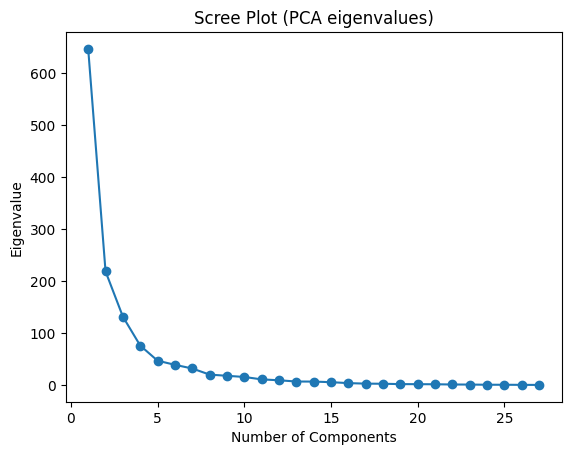

In [42]:
pca = PCA()
pca.fit(X)

ev = pca.explained_variance_

plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title('Scree Plot (PCA eigenvalues)')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.show()

In [43]:
n_factors = 5
fa = FactorAnalysis(n_components=n_factors, random_state=0)
factor_scores = fa.fit_transform(X)

In [44]:
fa_df = pd.DataFrame(
    factor_scores,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=demo_occ.index
)

In [45]:
loadings = pd.DataFrame(
    fa.components_.T,
    index=predictors,
    columns=fa_df.columns
)
print("Factor Loadings:\n", loadings)

Factor Loadings:
                           Factor1    Factor2   Factor3   Factor4   Factor5
nhw21p                   9.070571  10.305290 -5.166572  0.732293  0.949009
nhb21p                  -9.261266  -3.824086 -5.207459  4.678847 -0.229615
h21p                    -4.324040  -1.576377 -1.406687 -2.286042  1.423745
cvap21bapp               6.640523   5.384358 -6.011258 -3.715049 -2.437911
chin21p                 13.384047  -4.662909 -1.737327  0.018210  0.107052
kor21p                   4.316722  -1.454959 -0.845684  0.479302 -1.420686
white_transplant_ratio   0.320980   0.411111 -0.101229  0.133145 -0.063503
bang21p                 -1.898032  -0.777072 -0.038695 -0.559989  0.545791
pak21p                  -0.666544  -0.283347  0.391545 -0.164179 -0.190016
adams213p              -10.451866  -3.070529 -8.700955 -2.251400 -0.494190
domin21p                -1.097196  -0.063709 -0.385737 -0.302200  0.159285
prican21p               -0.679873  -0.305087 -0.184211 -0.318442 -0.418835
mex21p 

In [46]:
Y = demo_occ['vote_share']
model_fa = sm.OLS(Y, sm.add_constant(fa_df)).fit()
print(model_fa.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     19.57
Date:                Sun, 26 Oct 2025   Prob (F-statistic):           1.50e-13
Time:                        13:37:16   Log-Likelihood:                -360.40
No. Observations:                 106   AIC:                             732.8
Df Residuals:                     100   BIC:                             748.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.6619      0.725     32.636      0.0

Donation Ethnicity

In [3]:
from ethnicolr import pred_census_ln, pred_wiki_name

c:\Users\samtg\github\member_chapters\venv\Lib\site-packages\ethnicolr\pred_census_ln.py:14: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [4]:
lee_don = pd.read_csv('../data/lee_don.csv')
kaur_don = pd.read_csv('../data/kaur_don.csv')
lee_ind = lee_don[lee_don['C_CODE'] == 'IND']
kaur_ind = kaur_don[kaur_don['C_CODE'] == 'IND']

In [5]:
def split_name(name):
    if pd.isna(name):
        return pd.Series({"last":"", "first":""})
    name = str(name).strip()
    if ',' in name:
        last, first = name.split(',', 1)
        return pd.Series({"last": last.strip(), "first": first.strip()})
    parts = name.split()
    if len(parts) == 0:
        return pd.Series({"last":"", "first":""})
    if len(parts) == 1:
        return pd.Series({"last": parts[0], "first": ""})
    return pd.Series({"last": parts[-1], "first": " ".join(parts[:-1])})

In [6]:
name_parts = lee_ind['NAME'].apply(split_name)
lee_ind = pd.concat([lee_ind, name_parts], axis=1)
lee_ind['first'] = lee_ind['first'].astype(str)
lee_ind['last'] = lee_ind['last'].astype(str)

name_parts = kaur_ind['NAME'].apply(split_name)
kaur_ind = pd.concat([kaur_ind, name_parts], axis=1)
kaur_ind['first'] = kaur_ind['first'].astype(str)
kaur_ind['last'] = kaur_ind['last'].astype(str)

In [7]:
df = lee_ind[['first','last','NAME','ZIP','AMNT']]
orig_cols = set(df.columns)
lee_with_eth = pred_wiki_name(df.copy(), 'last', 'first')

2025-10-26 16:58:05,633 - INFO - Processing 638 names
2025-10-26 16:58:05,702 - INFO - Applying Wikipedia name model to 638 processable names (confidence interval: 1.0)
2025-10-26 16:58:05,729 - INFO - Preserving 67 duplicate rows based on column '__ethnicolr_temp_name'
2025-10-26 16:58:05,733 - INFO - Data filtering summary: 638 → 638 rows (kept 100.0%)
2025-10-26 16:58:08,002 - INFO - Successfully predicted 638 of 638 names (100.0%)
2025-10-26 16:58:08,004 - INFO - Added columns: GreaterAfrican,Africans, Asian,GreaterEastAsian,EastAsian, GreaterEuropean,WestEuropean,Italian, GreaterAfrican,Muslim, GreaterEuropean,Jewish, GreaterEuropean,WestEuropean,French, GreaterEuropean,WestEuropean,Germanic, name_normalized_clean, race, GreaterEuropean,British, Asian,IndianSubContinent, processing_status, GreaterEuropean,EastEuropean, GreaterEuropean,WestEuropean,Nordic, __name, GreaterEuropean,WestEuropean,Hispanic, name_normalized, Asian,GreaterEastAsian,Japanese


In [8]:
df = kaur_ind[['first','last','NAME','ZIP','AMNT']]
orig_cols = set(df.columns)
kaur_with_eth = pred_wiki_name(df.copy(), 'last', 'first')

2025-10-26 16:58:33,070 - INFO - Processing 1433 names
2025-10-26 16:58:33,130 - INFO - Applying Wikipedia name model to 1433 processable names (confidence interval: 1.0)
2025-10-26 16:58:33,140 - INFO - Preserving 339 duplicate rows based on column '__ethnicolr_temp_name'
2025-10-26 16:58:33,143 - INFO - Data filtering summary: 1433 → 1433 rows (kept 100.0%)
2025-10-26 16:58:34,625 - INFO - Successfully predicted 1433 of 1433 names (100.0%)
2025-10-26 16:58:34,625 - INFO - Added columns: GreaterAfrican,Africans, Asian,GreaterEastAsian,EastAsian, GreaterEuropean,WestEuropean,Italian, GreaterAfrican,Muslim, GreaterEuropean,Jewish, GreaterEuropean,WestEuropean,French, GreaterEuropean,WestEuropean,Germanic, name_normalized_clean, race, GreaterEuropean,British, Asian,IndianSubContinent, processing_status, GreaterEuropean,EastEuropean, GreaterEuropean,WestEuropean,Nordic, __name, GreaterEuropean,WestEuropean,Hispanic, name_normalized, Asian,GreaterEastAsian,Japanese


In [9]:
lee_with_eth.groupby('race')['AMNT'].agg(['mean','sum','count']).round(3).reset_index().sort_values('count',ascending=False)

,race,mean,sum,count
0,"Asian,GreaterEastAsian,EastAsian",153.630,52695.21,343
5,"GreaterEuropean,British",125.827,15980.00,127
7,"GreaterEuropean,Jewish",93.605,4025.00,43
2,"Asian,IndianSubContinent",95.143,3330.00,35
11,"GreaterEuropean,WestEuropean,Italian",111.923,2910.00,26
4,"GreaterAfrican,Muslim",54.792,1315.00,24
3,"GreaterAfrican,Africans",169.444,1525.00,9
6,"GreaterEuropean,EastEuropean",66.111,595.00,9
8,"GreaterEuropean,WestEuropean,French",260.333,2343.00,9
10,"GreaterEuropean,WestEuropean,Hispanic",74.429,521.00,7


In [10]:
kaur_with_eth.groupby('race')['AMNT'].agg(['mean','sum','count']).round(3).reset_index().sort_values('count',ascending=False)

,race,mean,sum,count
5,"GreaterEuropean,British",32.314,21294.66,659
7,"GreaterEuropean,Jewish",34.251,5925.48,173
2,"Asian,IndianSubContinent",44.841,6860.60,153
11,"GreaterEuropean,WestEuropean,Italian",40.922,3560.23,87
10,"GreaterEuropean,WestEuropean,Hispanic",31.532,2301.84,73
4,"GreaterAfrican,Muslim",34.822,2472.39,71
0,"Asian,GreaterEastAsian,EastAsian",36.794,2170.87,59
6,"GreaterEuropean,EastEuropean",30.503,1403.16,46
8,"GreaterEuropean,WestEuropean,French",31.252,1218.82,39
3,"GreaterAfrican,Africans",37.107,1039.00,28
